<h1><center> Using Python to unearth a goldmine of threat intelligence from leaked chat logs </center></h1>

<h2><center> Author: Thomas Roccia |<a href="https://twitter.com/fr0gger_">@fr0gger_</a></center></h2>

# Introduction

Dealing with a great amount of data can be time consuming, thus using Python can be very powerful  to help analysts sort information and extract the most relevant data for their investigation. The open-source tools library, MSTICpy, for example, is a tool dedicated to threat intelligence. It aims to help threat analysts acquire, enrich, analyze, and visualize data. In this notebook, we will explore the data in depth using Python. We will dissect the available information and learn more about their process and operation. Eventually, we will see how we can take advantage of the available information to pivot and hunt for additional context and threat intelligence using the MSTICpy library. 

This notebook will allow analysts to reuse the code and continue to search for the extracted information on their own. Additionally, it offers an out-of-the-box methodology for analyzing chat logs, extracting indicators of compromise, and improving threat intelligence and defense process using Python.

# What is the goal of this Notebook?
Through this notebook, we will explore the Conti Jabber leaks and provide a workflow of analysis using Python.

The notebook is composed of the following parts:
- The first part of this notebook will provide details of the available data as well as how to transform them for using it with Python and for Interpretation. 
- The second part will provide details about the Jabber logs as well as some visualization.
- The third part will be dedicated to threat intelligence, extracting relevant IOCs and pivoting with the extracted data. 

# Configuration
To use this notebook several library must be installed here is the list of the module, you can install them using pip. 
* pandas
* msticpy
* bokeh
* pyvis
* matplotlib
* treelib
* textsearch
* ipywidgets
* GoogleTranslator

# Exploring the Jabber Logs


## Compiling and translating the data

The leaked chat logs are written in the Russian language, requiring the data to be translated to English for analysis. We adopted the translation methodology published [here](https://twitter.com/AZobec/status/1498273950593392650?s=20&t=vHjpKwApde73B3x47Fk9Zg).. 

Since raw Jabber logs are saved using a file per day, they will need to be compiled in one JSON file so they can easily be manipulated with Python.
`cat *.json | jq -cr > ../merged.json`

Once the data is merged, they can be translated using the deep translator library. 

In [ ]:
# Code borrowed and adapted from @azobec
import json
from deep_translator import GoogleTranslator

# Creating the list
chatList = []

# opening the file merged.json
with open('merged2.json', encoding="utf8") as f:
    for jsonObj in f:
        logs = json.loads(jsonObj)
        chatList.append(logs)

# Creating and adding the translated logs into translated_log.json.
with open('translated_log3.json', 'a+', encoding="utf8") as outfile:
    outfile.write("[")    
    for line in chatList:
        try:
            translation = GoogleTranslator(source='auto', target='en').translate(line["body"])
            line["LANG-EN"] = translation
            
        # When a translation is not possible we handle the error and write a message
        except Exception as e:
            line["LANG-EN"] = "Error during Translation"
    
        outfile.write(json.dumps(line, ensure_ascii = False).encode('utf8').decode())
        outfile.write(",")
    outfile.write("]")    

 After the logs are translated and loaded into a new file, it’s then possible to load the data into a dataframe for manipulation and exploration.

## Loading the translated logs into a dataframe

In [1]:
# Loading the data in a dataframe
import codecs
import pandas as pd
from IPython.display import Image

df = pd.read_json(codecs.open('translated_Log2.json', 'r', 'utf-8'))

In [2]:
# Print some information about the loaded dataframe
df.head()

,ts,from,to,body,LANG-EN
0,2021-01-29T00:06:46.929363,mango@q3mcco35auwcstmt.onion,stern@q3mcco35auwcstmt.onion,"про битки не забудь, кош выше, я спать)","don't forget about cue balls, kosh is higher, ..."
1,2021-01-29T04:04:39.308133,mango@q3mcco35auwcstmt.onion,stern@q3mcco35auwcstmt.onion,привет,Hey
2,2021-01-29T04:04:43.474243,mango@q3mcco35auwcstmt.onion,stern@q3mcco35auwcstmt.onion,битков не хватит на все..,bits are not enough for everything ..
3,2021-01-29T04:32:02.648304,price@q3mcco35auwcstmt.onion,green@q3mcco35auwcstmt.onion,привет!!!,Hey!!!
4,2021-01-29T04:32:16.858754,price@q3mcco35auwcstmt.onion,green@q3mcco35auwcstmt.onion,опять прокладки сменились??? нет связи!,have the pads changed again? no connection!


## Slang translation

Russian slang words not properly translated by the automated process can be translated by creating a dictionary. A dictionary off a list proposed [here](https://twitter.com/seadev3/status/1498783071969099777?s=20&t=tIrZJsDdonKfyxAoEKJOQw) was used in this case to correctly translate the slang:  

In [3]:
# Creating a dictionnary with the translated slang words
slang = {"Hell": "AD", "YES": "DA", "wheelbarrow": "host", "cars": "hosts", "cue balls": "bitcoin", "credits":"credentials", "vmik":"WMIC", "grid":"network", "facial expressions":"mimikatz", "firework":"firewall", "whining":"SQL", "school":"SQL", "balls":"shares", "zithers":"Citrix", "food":"FUD", "silkcode":"shellcode", "kosh":"cash", "toad":"jabber", "booze":"Emotet", "the trick or trick": "Trickbot", "BC":"BazarBackdoor", "backpack":"Ryuk", "lock":"ransomware"}

# Replacing the words in the translated column
df['LANG-EN'] = df['LANG-EN'].replace(slang, regex=True)
df['LANG-EN'].head(10)

0    don't forget about bitcoin, cash is higher, I'...
1                                                  Hey
2                bits are not enough for everything ..
3                                               Hey!!!
4          have the pads changed again? no connection!
5                                                  Hey
6    hello sn today I'm waiting for cash and the am...
7                                                  Hey
8    bc1qy2083z665ux68zda3tfuh5xed2493uaj8whdwv - 0...
9                                               moment
Name: LANG-EN, dtype: object

## Analyzing the chat activity timeline 

<AxesSubplot:title={'center':'Number of discussion per day'}, xlabel='ts'>

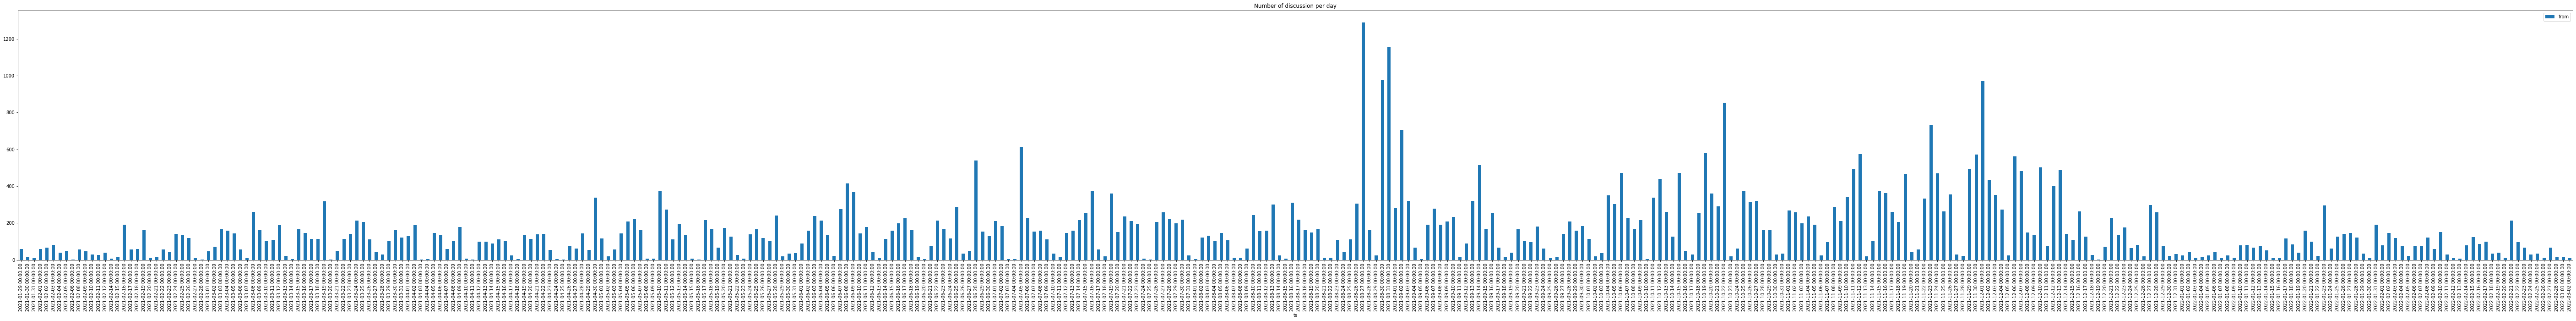

In [4]:
# Static graph, you can double click on the graphic to get more details
df['ts'] = pd.to_datetime(df['ts']).dt.date
df['ts'] = pd.to_datetime(df['ts'])

# Sorting the data by datetime
data = df.groupby(df['ts'])['from'].count()
data.plot(kind='bar',figsize=(100,10),legend=True, title="Number of discussion per day")

In [5]:
# Dynamic graph using Bokeh
import pandas_bokeh
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from msticpy.vis.figure_dimension import bokeh_figure

# wrap figure function to handle v2/v3 parameter renaming
figure = bokeh_figure(figure)

df['ts'] = pd.to_datetime(df['ts']).dt.date
df['ts'] = pd.to_datetime(df['ts'])

pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')

# Filter the result to manipulate only timestamp and number of discussion per day
data2 = pd.DataFrame(df.groupby(df['ts'])['from'].count().reset_index())

Loading BokehJS ...

In [6]:
# Loading the filtered dataset into ColumnDataSource
source = ColumnDataSource(data2)

# Creating the figure with the size

p = figure(x_axis_type='datetime', width=900, height=500)

# Adding the hover tools
p.add_tools(HoverTool(tooltips=[('Date', '@ts{%F}'), ('Nb of discussion','@from{int}')],
                      formatters={'@ts':'datetime'}, mode='mouse'))

# Legend
p.title.text ='Activity discussion per day'
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Number of discussion'

# diagram
p.line(x='ts', y='from', line_width=2, color='#851503', source=source)

# print the diagram
show(p)

## Searching in the logs

Reading all the leak can be a bit time consuming so it could be interesting to build a simple search engine to search for specific occurence of a string into the chat logs. That way we can filter to specific data of interest such as bitcoin, usernames, malware name, exploit, CVE... to name a few.

In [7]:
# Import lib 
import ipywidgets as widgets
from textsearch import TextSearch
from IPython.display import display

pd.set_option('display.max_colwidth', None)

#configure widget
keyword = widgets.Text(
    value='',
    placeholder='Enter your search',
    description='Search:',
    disabled=False
)
display(keyword)

# Configure click button
button = widgets.Button(description="search", icon='check') # (FontAwesome names without the `fa-` prefix))
display(button)

output = widgets.Output()

# Searching for the input word
@output.capture()
def userInput(b):
    
    # store the search result in a list
    result = []
    print("[+] Searching the chat for occurence of: " + keyword.value)
    
    # look for the string into the translated column
    for i in df['LANG-EN']:
        ts = TextSearch(case="ignore", returns="match")
        words = keyword.value
        ts.add(words)
        
        # store the result into the list
        if ts.findall(str(i)):
            result.append(i)
    
    # Filter and print the result
    result = list(dict.fromkeys(result))    
    print('\n'.join(map(str, result)))

# get the input word
button.on_click(userInput)
display(output)

Text(value='', description='Search:', placeholder='Enter your search')

Button(description='search', icon='check', style=ButtonStyle())

Output()

## Analyzing the level of user activity 

When analyzing chat logs, identifying the number of users and analyzing the most active ones can provide insight into the size of the group and roles of users within it. Using Python, the list of users can be extracted and saved in a text file.

In [8]:
# Extracting all the users
userfrom = df['from']
userto = df['to']

# Dropping duplicate and concatenate dataframe
user = pd.concat([userfrom.drop_duplicates(), userto.drop_duplicates()], ignore_index=True)
user = user.drop_duplicates()

# Save userlist to txt for additional hunting
user.to_csv(r'IOC\userlist.txt', header=None, index=None, sep='\t', mode='a')

In [9]:
# Static graphic
%matplotlib inline
df.groupby('from').count().ts.sort_values(ascending=False).iloc[:50].plot.barh(figsize=(15,10), title="Most active users")

Figure(id='1218', ...)

In [10]:
# Filtering and extracting the 10 most active users
user = pd.DataFrame(df.groupby('from').count().ts.sort_values(ascending=False).reset_index())
user.columns = user.columns.str.replace('ts', 'count')
user.head(10)

,from,count
0,defender@q3mcco35auwcstmt.onion,8246
1,stern@q3mcco35auwcstmt.onion,4323
2,driver@q3mcco35auwcstmt.onion,3968
3,bio@q3mcco35auwcstmt.onion,3196
4,mango@q3mcco35auwcstmt.onion,3194
5,ttrr@conference.q3mcco35auwcstmt.onion,3122
6,veron@q3mcco35auwcstmt.onion,2955
7,hof@q3mcco35auwcstmt.onion,2389
8,bentley@q3mcco35auwcstmt.onion,1810
9,bloodrush@q3mcco35auwcstmt.onion,1798


## Mapping the users’ connections 

In [11]:
# Transforming the data, the weight corresponding to the number of message send between 2 users. 
df_weight = df.groupby(["from", "to"], as_index=False).count()
df_weight = df_weight.drop(['body','LANG-EN'], axis = 1)
df_weight.columns = df_weight.columns.str.replace('ts', 'weight')
df_weight.head(5)

,from,to,weight
0,admin@expiro-team.biz,qwerty@q3mcco35auwcstmt.onion,1
1,admin@q3mcco35auwcstmt.onion,demon@q3mcco35auwcstmt.onion,10
2,admin@q3mcco35auwcstmt.onion,wind@q3mcco35auwcstmt.onion,1
3,admin@q3mcco35auwcstmt.onion,zevs@q3mcco35auwcstmt.onion,6
4,admintest@q3mcco35auwcstmt.onion,revers@q3mcco35auwcstmt.onion,15


In [14]:
# Importing the pyvis lib
from pyvis.network import Network

# Configuring the graph option
conti_net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white', notebook = True)

# set the physics layout of the network, here we used the barnes hut
conti_net.barnes_hut()
conti_data = df_weight

# Split the data
sources = conti_data['from']
targets = conti_data['to']
weights = conti_data['weight']

edge_data = zip(sources, targets, weights)

# Browsing the data to construct the network graph
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    
    conti_net.add_node(src, src, title=src)
    conti_net.add_node(dst, dst, title=dst)
    conti_net.add_edge(src, dst, value=w*10)
        
neighbor_map = conti_net.get_adj_list()

# add user data to node hover data
for node in conti_net.nodes:
    node['title'] += ' <br> - Discussion with:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])
    
conti_net.show('conti_leak.html')

# Using MSTICPy to extract and analyze IOCs 

Besides processing chat logs to analyze user activity and connections, Python can also be used to extract and analyze threat intelligence. This section shows how the MSTICPy library can be used to extract IOCs and how it can be used for additional threat hunting and intelligence. 

## Loading MSTICpy

In [15]:
# Imports and configuration
from IPython.display import display, HTML
from msticpy.sectools import IoCExtract
import matplotlib.pyplot as plt
import sys
import warnings
from msticpy import init_notebook
init_notebook(namespace=globals());

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

## Extracting IOCs 

MSTICPy is a Python library used for threat investigation and threat hunting. The library can connect to several threat intelligence providers, as well as Microsoft tools like Microsoft Sentinel. It can be used to query logs and to enrich data. It’s particularly convenient for analyzing IOCs and adding more threat contextualization.  

In [16]:
# We clean the dataframe to remove None value
df['LANG-EN'] = df['LANG-EN'].fillna('').apply(str)

# Initiate the IOC extractor
ioc_extractor = IoCExtract()
ioc_df = ioc_extractor.extract(data = df, columns = ['LANG-EN'])

display(HTML("<h4>IoC patterns found in chat logs.</h4>"))
display(ioc_df.head(10))

,IoCType,Observable,SourceIndex,Input
0,dns,qaz.im,23,https://qaz.im/load/Tb6rNh/dYkYy2
1,url,https://qaz.im/load/Tb6rNh/dYkYy2,23,https://qaz.im/load/Tb6rNh/dYkYy2
2,dns,qaz.im,25,https://qaz.im/load/hzkQTQ/BTa6Ze
3,url,https://qaz.im/load/hzkQTQ/BTa6Ze,25,https://qaz.im/load/hzkQTQ/BTa6Ze
4,dns,qaz.im,29,https://qaz.im/load/Tb6rNh/dYkYy2
5,url,https://qaz.im/load/Tb6rNh/dYkYy2,29,https://qaz.im/load/Tb6rNh/dYkYy2
6,dns,qaz.im,52,https://qaz.im/load/hzkQTQ/BTa6Ze
7,url,https://qaz.im/load/hzkQTQ/BTa6Ze,52,https://qaz.im/load/hzkQTQ/BTa6Ze
8,ipv6,09:54:30,54,"[09:54:30] <22> throw it right away. until March 1, whatever. and then you waste it on trifles a..."
9,ipv6,09:55:17,54,"[09:54:30] <22> throw it right away. until March 1, whatever. and then you waste it on trifles a..."


In [17]:
# Extracting BTC addresses
# Adding the regex
extractor = IoCExtract()
extractor.add_ioc_type(ioc_type='btc', ioc_regex='^(?:[13]{1}[a-km-zA-HJ-NP-Z1-9]{26,33}|bc1[a-z0-9]{39,59})$')

# Check that it added ok
print(extractor.ioc_types['btc'])

# Use it in our data set and create a new df
btc_df = ioc_extractor.extract(data=df, columns=['LANG-EN']).query('IoCType == \'btc\'')

display(HTML("<h4>BTC addresses found in chat logs.</h4>"))
display(btc_df.head(10))

IoCPattern(ioc_type='btc', comp_regex=re.compile('^(?:[13]{1}[a-km-zA-HJ-NP-Z1-9]{26,33}|bc1[a-z0-9]{39,59})$', re.IGNORECASE|re.MULTILINE|re.VERBOSE), priority=0, group=None)


,IoCType,Observable,SourceIndex,Input
152,btc,bc1q3efl4m2jcr6gk32usxnfyrxh294sr8plmpe3ye,806,bc1q3efl4m2jcr6gk32usxnfyrxh294sr8plmpe3ye
213,btc,1MxtwUpH4cWAz4en4kqVNzAdx5gpk9etUC,1131,"hello, the bitcoins are over, in total 6 new servers, two vpn subscriptions, an ipvanish subscri..."
214,btc,1MxtwUpH4cWAz4en4kqVNzAdx5gpk9etUC,1136,"hello, the bitcoins are over, in total 6 new servers, two vpn subscriptions, an ipvanish subscri..."
296,btc,bc1qnf6drcfl786d70wlhfytyr5xg3qqgknlsh8dc3,1606,bc1qnf6drcfl786d70wlhfytyr5xg3qqgknlsh8dc3
297,btc,17mc4Qm7ka9jhQEUB5LTxP3gW3tsDYUJGQ,1608,"hello, the cue ball is over, in total 8 new servers, two vpn subscriptions, and 18 renewals have..."
307,btc,bc1qnf6drcfl786d70wlhfytyr5xg3qqgknlsh8dc3,1617,bc1qnf6drcfl786d70wlhfytyr5xg3qqgknlsh8dc3
308,btc,17mc4Qm7ka9jhQEUB5LTxP3gW3tsDYUJGQ,1619,"hello, the cue ball is over, in total 8 new servers, two vpn subscriptions, and 18 renewals have..."
329,btc,bc1qy2083z665ux68zda3tfuh5xed2493uaj8whdwv,1669,bc1qy2083z665ux68zda3tfuh5xed2493uaj8whdwv
330,btc,172KVKhMqL5CU1HN884RbArzu5DDL5hwE3,1680,172KVKhMqL5CU1HN884RbArzu5DDL5hwE3\n\n0.01523011
335,btc,bc1qc39qwc3nl2eyh2cu4ct6tyh9zqzp9ye993c0y2,1716,bc1qc39qwc3nl2eyh2cu4ct6tyh9zqzp9ye993c0y2


In [18]:
display(HTML("<h4>Merging, filtering and sorting</h4>"))
# Merging dataframe

ioc_df = pd.concat([ioc_df, btc_df], axis=0).drop_duplicates(subset='Observable').reset_index(drop=True)
#ioc_df = ioc_df.drop_duplicates(subset='Observable', inplace=True)

# Removing IPV6 rows because they are false positive
ioc_df = ioc_df[ioc_df["IoCType"].str.contains("ipv6") == False]

ioc_df

,IoCType,Observable,SourceIndex,Input
0,dns,qaz.im,23,https://qaz.im/load/Tb6rNh/dYkYy2
1,url,https://qaz.im/load/Tb6rNh/dYkYy2,23,https://qaz.im/load/Tb6rNh/dYkYy2
2,url,https://qaz.im/load/hzkQTQ/BTa6Ze,25,https://qaz.im/load/hzkQTQ/BTa6Ze
6,url,https://qaz.im/load/3EZGA7/4SEstA,103,https://qaz.im/load/3EZGA7/4SEstA
21,ipv4,54.183.140.39,228,"yep, they all worked\nexcept\nbot\n54.183.140.39"
...,...,...,...,...
4241,btc,1G5LWXMN42ueD2eWvm4zMrhXGihghHDgMq,59405,1G5LWXMN42ueD2eWvm4zMrhXGihghHDgMq\nAmount $1000
4242,btc,bc1qr8fw0xj28emurqhu8k7gj4llzgnxf4dejhl04h,59913,"hello, I turned to the defender to clarify the situation with the salary, he replied that now it..."
4243,btc,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,60385,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6
4244,btc,33hiG13GTHTV2G8aZxzBJHBPBpDNevcK2B,60542,33hiG13GTHTV2G8aZxzBJHBPBpDNevcK2B


In [19]:
# Save IOC to CSV
ioc_df.to_csv("IOC\\full_ioc.csv")

# Overview of the IOC in the dataset
ioc_df["IoCType"].value_counts()

url            1137
dns             474
ipv4            317
btc             175
md5_hash        106
sha256_hash      16
sha1_hash         2
Name: IoCType, dtype: int64

## Cleaning the extracted IOCs

In [20]:
ioc_df = ioc_df[ioc_df["Observable"].str.contains("privnote.com")==False ]
ioc_df = ioc_df[ioc_df["Observable"].str.contains("qaz.im")==False ]

In [21]:
ioc_df

,IoCType,Observable,SourceIndex,Input
21,ipv4,54.183.140.39,228,"yep, they all worked\nexcept\nbot\n54.183.140.39"
24,dns,2Fwwwapps.ups.com,335,1Z9918AW3591558812 <https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2F...
25,dns,hura.me,335,1Z9918AW3591558812 <https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2F...
26,url,https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2Ftrack%3FHTMLtrackVer...,335,1Z9918AW3591558812 <https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2F...
27,url,https://hura.me/no-ref.php?url=http://wwwapps.ups.com/WebTracking/track?HTMLtrackVersion=5.0&loc...,335,1Z9918AW3591558812 <https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2F...
...,...,...,...,...
4241,btc,1G5LWXMN42ueD2eWvm4zMrhXGihghHDgMq,59405,1G5LWXMN42ueD2eWvm4zMrhXGihghHDgMq\nAmount $1000
4242,btc,bc1qr8fw0xj28emurqhu8k7gj4llzgnxf4dejhl04h,59913,"hello, I turned to the defender to clarify the situation with the salary, he replied that now it..."
4243,btc,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,60385,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6
4244,btc,33hiG13GTHTV2G8aZxzBJHBPBpDNevcK2B,60542,33hiG13GTHTV2G8aZxzBJHBPBpDNevcK2B


## IP Addresses Intelligence

In [22]:
df_ip = ioc_df.loc[ioc_df["IoCType"] == "ipv4"]
df_ip['IoCType'].count()

317

In [23]:
# load all configured providers
ti_lookup = TILookup(providers = ["VirusTotal", "GreyNoise", "OTX"])
ti_lookup.provider_status

['GreyNoise - GreyNoise Lookup. (primary)',
 'OTX - AlientVault OTX Lookup. (primary)',
 'VirusTotal - VirusTotal Lookup. (primary)']

In [24]:
# Don't forget to reload the providers once you specified the api key in the config file. 
ti_lookup.reload_providers()

Settings reloaded. Use reload_providers to update settings for loaded providers.


In [25]:
ip_intel = ti_lookup.lookup_iocs(data = df_ip["Observable"])
ip_intel.head(10)

,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,54.183.140.39,ipv4,54.183.140.39,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/54.183.140.39,404
1,5.139.220.204,ipv4,5.139.220.204,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/5.139.220.204,404
2,138.124.180.94,ipv4,138.124.180.94,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/138.124.180.94,404
3,45.14.226.47,ipv4,45.14.226.47,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/45.14.226.47,404
4,193.203.203.101,ipv4,193.203.203.101,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/193.203.203.101,404
5,173.163.176.177,ipv4,173.163.176.177,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/173.163.176.177,404
6,75.151.48.49,ipv4,75.151.48.49,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/75.151.48.49,404
7,71.105.126.26,ipv4,71.105.126.26,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/71.105.126.26,404
8,96.70.44.17,ipv4,96.70.44.17,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/96.70.44.17,404
9,96.93.217.253,ipv4,96.93.217.253,None,GreyNoise,False,information,Not found.,<Response [404 Not Found]>,https://api.greynoise.io/v3/community/96.93.217.253,404


In [26]:
# Saving the IP into a csv file.
ip_intel.to_csv("IOC\\ipintel.csv")

In [27]:
# Removing the ip with severity == information
ip_intel = ip_intel[ip_intel["Severity"].str.contains("information")==False ]

In [28]:
# You can also make a request for a single IP.
result = ti_lookup.lookup_ioc(observable="203.76.105.227")
ti_lookup.result_to_df(result).T

,GreyNoise,OTX,VirusTotal
Ioc,203.76.105.227,203.76.105.227,203.76.105.227
IocType,ipv4,ipv4,ipv4
QuerySubtype,None,None,None
Provider,GreyNoise,OTX,VirusTotal
Result,False,True,True
Severity,information,high,information
Details,Not found.,"{'pulse_count': 3, 'names': ['IoC Ransomware CONTI', 'Conti Ransomware | CISA', 'Conti Ransomwar...","{'verbose_msg': 'IP address in dataset', 'response_code': 1, 'positives': 0, 'detected_urls': []..."
RawResult,<Response [404 Not Found]>,"{'whois': 'http://whois.domaintools.com/203.76.105.227', 'reputation': 0, 'indicator': '203.76.1...","{'asn': 23688, 'undetected_urls': [], 'undetected_downloaded_samples': [{'date': '2021-05-25 16:..."
Reference,https://api.greynoise.io/v3/community/203.76.105.227,https://otx.alienvault.com/api/v1/indicators/IPv4/203.76.105.227/general,https://www.virustotal.com/vtapi/v2/ip-address/report
Status,404,0,0


## Browsing the result

In [29]:
from msticpy.nbtools.ti_browser import browse_results
ip_intel = pd.read_csv("IOC\\ipintel.csv")

ti_selector = browse_results(data = ip_intel, height="200px")
ti_selector

## Creating a Map with the IP addresses

In [30]:
# Getting the geo result for one ip
msticpy.settings.refresh_config()
iplocation = GeoLiteLookup()

loc_result, ip_entity = iplocation.lookup_ip(ip_address = '203.76.105.227')
display(ip_entity[0])

Latest local Maxmind City Database present is older than 30 days. Attempting to download new database to C:\Users\thomasroccia\.msticpy
Extraction complete. Local Maxmind city DB: C:\Users\thomasroccia\.msticpy\GeoLite2-City.mmdb.19544.tar.gz


IpAddress(Address=203.76.105.227, Location={ 'City': 'Dhaka',
  'CountryCode': 'BD',
  'Co...)

In [31]:
# Creating the map using the folium module
iploc = []

for ip in ip_intel["Ioc"]:
    loc_result, ip_entity = iplocation.lookup_ip(ip_address = ip)
    iploc += ip_entity

folium_map = FoliumMap(zoom_start = 2)
folium_map.add_ip_cluster(ip_entities = iploc, color = 'red')
folium_map.center_map()
folium_map

## URL Intelligence

In [32]:
# Filtering URL
url_intel = ioc_df.loc[(ioc_df['IoCType'] == "url")]
url_intel

,IoCType,Observable,SourceIndex,Input
26,url,https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2Ftrack%3FHTMLtrackVer...,335,1Z9918AW3591558812 <https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2F...
27,url,https://hura.me/no-ref.php?url=http://wwwapps.ups.com/WebTracking/track?HTMLtrackVersion=5.0&loc...,335,1Z9918AW3591558812 <https://hura.me/no-ref.php?url=http%3A%2F%2Fwwwapps.ups.com%2FWebTracking%2F...
41,url,https://dyncheck.com/scan/id/fbcb147447b24f5c583f710fafc5b214#collapse_info,514,+] Written in Jscript can be used as .js or .vbs\n[+] Small size (14 KB ~)\n[+] Support for all ...
42,url,https://dyncheck.com/scan/id/84b7fe1b0f95031d2e5eaedf9fa2dbe2#collapse_info,514,+] Written in Jscript can be used as .js or .vbs\n[+] Small size (14 KB ~)\n[+] Support for all ...
46,url,https://prnt.sc/wh26pt,516,Panel:\n\nhttps://prnt.sc/wh26qd\nhttps://prnt.sc/wh26rb\nhttps://prnt.sc/wh26pt
...,...,...,...,...
3984,url,https://temp.sh/HXmZA/СникzarBackdoorок,60165,https://temp.sh/HXmZA/%D0%A1%D0%BD%D0%B8%D0%BazarBackdoor%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0...
4027,url,http://l66orrehfw4hovqme625bavlpz7m2achabov3iyqy76cai44oao6neqd.onion/zeh7dkwfdxw99tdk/#/chat/f3...,60643,Hey ! how come they decipher Fail ZGQB3V6qmIWHLAwDH4dw4ijjACAknqMO2vvVBERGCICHODV86ciJyer49HHhAb...
4029,url,https://continews.click/uImgrfqk_WARNING,60646,https://continews.click/uImgrfqk_WARNING
4030,url,https://send.exploit.in/download/8bcac089623fcf96/#Kr27VSxYFrdmUHELZDJF1w,60658,https://send.exploit.in/download/8bcac089623fcf96/#Kr27VSxYFrdmUHELZDJF1w


In [33]:
# Saving to csv file
url_intel.to_csv("IOC\\urlintel.csv")

In [34]:
# Sorting the value
url_intel.sort_values('Observable', ascending = True)

,IoCType,Observable,SourceIndex,Input
1811,url,file://157.230.60.143/download.jpg,21267,[07/27/2021 19:01:56] <rozteka> https://www.ired.team/offensive-security/initial-access/netntlmv...
3875,url,ftp://5.183.95.6/uploads/Team_D/,58179,"ADo, can you crypt ftp://5.183.95.6/uploads/Team_D/"
233,url,ftp://himemsys:antiDen4ik@,3118,kramer> rdp rdp://SERVER-AGM\ella:[PLACEHOLDER][----REDACTED-----]...
2148,url,http://(IP)/TAG/TEST_W639600.1234A242341C6D1A25B3F315D688968E/84/,29277,На запрос вида \ncurl -X POST -F 'data=dXNlcg==|IE||||1240428288|1240428288|dXNlcg==|IE|demdex.n...
1380,url,http://109.230.199.73/209.dll,15237,http://109.230.199.73/209.dll\nhttp://109.230.199.73/209x64.exe
...,...,...,...,...
1241,url,https://www.zoominfo.com/c/xerox-corporation/194101651,12123,"Доброе утро бро , заразили xerox \nи ticket master https://www.zoominfo.com/c/ticketmaster-enter..."
1880,url,https://xflemdsxjrjilw34dsxpvrxp5whnaut7hc5xejwuqs6eqrkt77bxkwid.onion,21800,https://xflemdsxjrjilw34dsxpvrxp5whnaut7hc5xejwuqs6eqrkt77bxkwid.onion\nganesh: fp6fqpVxlrYsorC5...
1255,url,https://xzu6o2ni3hplvpmx.onion,12638,for HORSE\nrobotbander@jabb.im\n4815162342@jabb.im\nsheppard@jabber.ru\nsectorzero@jabb.im\n\n\n...
1355,url,https://yadi.sk/d/ySGgFr0ksqAp3Q,14870,[09:41:53] <mango> https://yadi.sk/d/ySGgFr0ksqAp3Q - examples of web artist's work


### Extracting url containing specific extension

In [35]:
# It could be interesting to filter to dll, jpg, exe, onion
url_intel[url_intel['Observable'].str.contains(".exe|.dll|.jpg|.zip|.7z|.rar|.png")]

,IoCType,Observable,SourceIndex,Input
221,url,https://help4windows.com/windows_7_shell32_dll.shtml,3064,https://help4windows.com/windows_7_shell32_dll.shtml
373,url,https://oividaluxuosa.com/ke/miami.dll,5275,"https://oividaluxuosa.com/ke/miami.dll , 3k copies with some neutral names so that the def does ..."
564,url,https://privatlab.com/s/v/nRl7zbAAjltBeLbRqrax,6661,Check if it works\nhttps://privatlab.com/s/v/nRl7zbAAjltBeLbRqrax\n123123
600,url,https://emploimed.com/netr.dll,7147,1st link https://emploimed.com/netr.dll
602,url,https://www.ottenbourg.com/chester.dll,7149,2nd link https://www.ottenbourg.com/chester.dll
728,url,https://anonfiles.com/Hai0P8t1uc/Dolfs_rar,7742,https://anonfiles.com/Hai0P8t1uc/Dolfs_rar\npass - AF2gAS2ggd
778,url,https://atlantisprojects.ca/cheryasd.dll,8169,https://atlantisprojects.ca/cheryasd.dll
783,url,https://parkisolutions.com/nerugin.dll,8197,https://parkisolutions.com/nerugin.dll
942,url,http://109.230.199.73/k.exe,9765,<off> http://109.230.199.73/k.exe\n[13.05.2021 08:33:36] <off> http://109.230.199.73/k.dll\n[13....
943,url,http://109.230.199.73/k.dll,9765,<off> http://109.230.199.73/k.exe\n[13.05.2021 08:33:36] <off> http://109.230.199.73/k.dll\n[13....


### Extracting onion domains

In [37]:
url_intel[url_intel['Observable'].str.contains(".onion")]

,IoCType,Observable,SourceIndex,Input
287,url,https://43oxsnqlub6aydymkwpn3agaaj7u2qexx4vwybgrwug46c6yldhuheid.onion/crpanel/,4306,https://43oxsnqlub6aydymkwpn3agaaj7u2qexx4vwybgrwug46c6yldhuheid.onion/crpanel/
741,url,https://dnog7cgicmkrvugrfxexo34gikjbr54sd5skxj4r42aj4tuy2hjsw6qd.onion,7860,Ready to access the admin panel (storage)\n[19:09:18] <bentley> https://dnog7cgicmkrvugrfxexo34g...
936,url,http://epyclq65gskclmpu.onion:1337,9751,http://epyclq65gskclmpu.onion:1337 - our file cleaner. will be on the SIA bransomwarechain
1211,url,http://ozpve456vdzplanabllomqi6lfx67nlrrthquvcsrfxv7z3jreurmfqd.onion,11755,http://ozpve456vdzplanabllomqi6lfx67nlrrthquvcsrfxv7z3jreurmfqd.onion\nadmin\n[{/.)B4xcE3v=fd6
1218,url,http://crdclub4wraumez4.onion/,11827,a cow was sold http://korovka32xc3t5cg.onion support@korovka.name and a card like http://crdclub...
1219,url,http://korovka32xc3t5cg.onion,11827,a cow was sold http://korovka32xc3t5cg.onion support@korovka.name and a card like http://crdclub...
1255,url,https://xzu6o2ni3hplvpmx.onion,12638,for HORSE\nrobotbander@jabb.im\n4815162342@jabb.im\nsheppard@jabber.ru\nsectorzero@jabb.im\n\n\n...
1321,url,http://i5rxdyozq7uyotqtmcj4hxq7modmxklejqysurqsf5ixhzw444jynvyd.onion/adminjx1p8zu25dr4ae7o.php?...,14250,http://i5rxdyozq7uyotqtmcj4hxq7modmxklejqysurqsf5ixhzw444jynvyd.onion/adminjx1p8zu25dr4ae7o.php?...
1675,url,https://auk64p35qebertdsh576avhnswxdprft3kpmvsm5sixxof6bsbgryxqd.onion/logpost/more_ex/D1F299F1B...,19733,now again on the command dll flies error\nhttps://bradiolum.top/aprel.dll\n\nhttps://auk64p35qeb...
1880,url,https://xflemdsxjrjilw34dsxpvrxp5whnaut7hc5xejwuqs6eqrkt77bxkwid.onion,21800,https://xflemdsxjrjilw34dsxpvrxp5whnaut7hc5xejwuqs6eqrkt77bxkwid.onion\nganesh: fp6fqpVxlrYsorC5...


### Extracting Prnt

In [39]:
url_intel[url_intel['Observable'].str.contains("prntscr.com|prnt.sc")]

,IoCType,Observable,SourceIndex,Input
46,url,https://prnt.sc/wh26pt,516,Panel:\n\nhttps://prnt.sc/wh26qd\nhttps://prnt.sc/wh26rb\nhttps://prnt.sc/wh26pt
47,url,https://prnt.sc/wh26rb,516,Panel:\n\nhttps://prnt.sc/wh26qd\nhttps://prnt.sc/wh26rb\nhttps://prnt.sc/wh26pt
48,url,https://prnt.sc/wh26qd,516,Panel:\n\nhttps://prnt.sc/wh26qd\nhttps://prnt.sc/wh26rb\nhttps://prnt.sc/wh26pt
243,url,https://prnt.sc/10ni7xz,3370,https://prnt.sc/10ni7xz broa what is it?
535,url,https://prnt.sc/11cdg8c,6368,https://prnt.sc/11cdg8c
555,url,https://prnt.sc/11h59lg,6578,"now I’ve made an emphasis on spam, I’m sending it to collect cc from a fake epla, now I’ve remad..."
556,url,https://prnt.sc/11h4zwh,6578,"now I’ve made an emphasis on spam, I’m sending it to collect cc from a fake epla, now I’ve remad..."
557,url,https://prnt.sc/11h4w3v,6578,"now I’ve made an emphasis on spam, I’m sending it to collect cc from a fake epla, now I’ve remad..."
558,url,https://prnt.sc/11h5bqx-gmail,6578,"now I’ve made an emphasis on spam, I’m sending it to collect cc from a fake epla, now I’ve remad..."
559,url,https://prnt.sc/11h58ex,6578,"now I’ve made an emphasis on spam, I’m sending it to collect cc from a fake epla, now I’ve remad..."


## Bitcoin Tracking

In [40]:
btc_intel = ioc_df.loc[(ioc_df['IoCType'] == "btc")]
btc_intel.head(10)

,IoCType,Observable,SourceIndex,Input
4071,btc,bc1q3efl4m2jcr6gk32usxnfyrxh294sr8plmpe3ye,806,bc1q3efl4m2jcr6gk32usxnfyrxh294sr8plmpe3ye
4072,btc,1MxtwUpH4cWAz4en4kqVNzAdx5gpk9etUC,1131,"hello, the bitcoins are over, in total 6 new servers, two vpn subscriptions, an ipvanish subscri..."
4073,btc,bc1qnf6drcfl786d70wlhfytyr5xg3qqgknlsh8dc3,1606,bc1qnf6drcfl786d70wlhfytyr5xg3qqgknlsh8dc3
4074,btc,17mc4Qm7ka9jhQEUB5LTxP3gW3tsDYUJGQ,1608,"hello, the cue ball is over, in total 8 new servers, two vpn subscriptions, and 18 renewals have..."
4075,btc,bc1qy2083z665ux68zda3tfuh5xed2493uaj8whdwv,1669,bc1qy2083z665ux68zda3tfuh5xed2493uaj8whdwv
4076,btc,172KVKhMqL5CU1HN884RbArzu5DDL5hwE3,1680,172KVKhMqL5CU1HN884RbArzu5DDL5hwE3\n\n0.01523011
4077,btc,bc1qc39qwc3nl2eyh2cu4ct6tyh9zqzp9ye993c0y2,1716,bc1qc39qwc3nl2eyh2cu4ct6tyh9zqzp9ye993c0y2
4078,btc,1LLRL4vZajTtpjuBh5VpBD8zUg73CHUsq3,1772,1LLRL4vZajTtpjuBh5VpBD8zUg73CHUsq3
4079,btc,1Q6SsW88b94a4P3Rxtfr4pRxvhqqJAWvEc,2868,"hello, cue ball is over, in total there are two av licenses, three new servers, three vpn subscr..."
4080,btc,12YQDqmq3t6bCKPKMRWFmqrju4UMXbcqvF,4561,"hello, the beats are over, in total 4 new servers, 3 vpn subscriptions, ipvaninsh subscription a..."


In [41]:
# Visualizing transaction for a single BTC address
your_btc_address = 'bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6' # Genesis Block
transactions_url = 'https://blockchain.info/rawaddr/' + your_btc_address
df_btc = pd.read_json(transactions_url)
df_btc

,hash160,address,n_tx,n_unredeemed,total_received,total_sent,final_balance,txs
0,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': '2b4c26e565d0be930ae6e817b703b1aa6ba731da7ba4705e81c2bb5d7ecfb967', 'ver': 1, 'vin_sz':..."
1,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': '336e8d542047377aa13fb73e41a8e59cf5feba9b2b646547a04cdb2a57472eed', 'ver': 1, 'vin_sz':..."
2,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': 'e5954c3d0552fa10abf9a9639ea3949ef154dccbe5fbecdd6e1afd34fb9dfd60', 'ver': 2, 'vin_sz':..."
3,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': 'a6409ef7e1e99baad3ec7ae1063be56820f870db79da91244d82eac79ff922b5', 'ver': 2, 'vin_sz':..."
4,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': 'bde120466b01e79ac3874033655a91aac0f0753ffaa8b2ebe804663d160418d5', 'ver': 1, 'vin_sz':..."
5,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': '60c05b7fc440a8c321510866a32d6bc29c78686b22283d5ef0ffc97cd4a91912', 'ver': 2, 'vin_sz':..."
6,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': 'ed559bc70719af3706623a3db2ed921c3e5dce84b2ec61a201cfb0181e85393a', 'ver': 1, 'vin_sz':..."
7,31b2fe08ed09d4fdcffe051d1ea8452544801703,bc1qxxe0uz8dp820mnl7q5w3a2z9y4zgq9cr6smlf6,8,0,229800000,229800000,0,"{'hash': '74066e28cfed92b06ead14059fcab65e825a302cc036096a31869bf5e8b8a1c0', 'ver': 2, 'vin_sz':..."


## Pivoting through the IOCs using VirusTotal

### Loading Modules

In [44]:
# Loading the VT API key
from msticpy.common.provider_settings import get_provider_settings
from msticpy.sectools.vtlookupv3 import VTLookupV3, VTEntityType
import nest_asyncio
vt_key = get_provider_settings("TIProviders")["VirusTotal"].args["AuthKey"]

# Instantiate vt_lookup object
vt_lookup = VTLookupV3(vt_key)
nest_asyncio.apply()

### Extracting information from an IP

In [45]:
# Instantiate vt_lookup object
IP = "109.230.199.73"
ip_relation = vt_lookup.lookup_ioc_relationships(observable = IP, vt_type = 'ip_address', relationship = 'downloaded_files')
ip_relation

,index,target_type,target,source,source_type,relationship_type
0,0,file,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,109.230.199.73,ip_address,downloaded_files
1,1,file,889e89b7c88b217f02e2b8ee54f7ee142aeb3fd60a1bd002482664a1dc8ba4ae,109.230.199.73,ip_address,downloaded_files
2,2,file,a738cf48df8b168e783a8728baac0d208298361a696ef219de01faeba030316f,109.230.199.73,ip_address,downloaded_files
3,3,file,21145b7f20221b447d2b58ca5aaa17f6eedba1f8aa2ed91ca5ffd696cc560868,109.230.199.73,ip_address,downloaded_files
4,4,file,d2c9f693a2080c6382a0a29d74a1b5cb13a1deeb5dbe7ff1427a669ddf66f59e,109.230.199.73,ip_address,downloaded_files
5,5,file,37ce6b6f7a4026a69784ee202283bb4d9f13651b84cb1abaec0ca4f359514a0b,109.230.199.73,ip_address,downloaded_files
6,6,file,a4dc4dd1ddb449490d236dd1cbf087fbdf7f923616a9948bf32b28eff03e57c9,109.230.199.73,ip_address,downloaded_files
7,7,file,61ca39fe6ad7c054484810ba7ca1f292efab2399a5607f42006d088302f07efc,109.230.199.73,ip_address,downloaded_files
8,8,file,fe52c23ae690d0dcf2bda89c7ed75f798d2d94beaabed014de5b76159f336f5e,109.230.199.73,ip_address,downloaded_files
9,9,file,83e285b9347fd74af8cb9c1962f584191325a98b50b2a6df6738aacd0c8054db,109.230.199.73,ip_address,downloaded_files


### Obtaining more details about a specific hash

In [46]:
hash_details = vt_lookup.get_object("cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58", "file")
hash_details

,id,type,type_description,tlsh,vhash,trid,creation_date,names,last_modification_date,type_tag,capabilities_tags,size,authentihash,times_submitted,last_submission_date,meaningful_name,downloadable,sha256,type_extension,tags,crowdsourced_ids_results,last_analysis_date,unique_sources,first_submission_date,sha1,...,last_analysis_results.Fortinet.method,last_analysis_results.Fortinet.engine_update,last_analysis_results.AVG.category,last_analysis_results.AVG.engine_name,last_analysis_results.AVG.engine_version,last_analysis_results.AVG.result,last_analysis_results.AVG.method,last_analysis_results.AVG.engine_update,last_analysis_results.Cybereason.category,last_analysis_results.Cybereason.engine_name,last_analysis_results.Cybereason.engine_version,last_analysis_results.Cybereason.result,last_analysis_results.Cybereason.method,last_analysis_results.Cybereason.engine_update,last_analysis_results.Panda.category,last_analysis_results.Panda.engine_name,last_analysis_results.Panda.engine_version,last_analysis_results.Panda.result,last_analysis_results.Panda.method,last_analysis_results.Panda.engine_update,sigma_analysis_stats.high,sigma_analysis_stats.medium,sigma_analysis_stats.critical,sigma_analysis_stats.low,context_attributes
0,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,Win32 DLL,T110049E14B2A914FBEE6A82B984935611B07174624338DFEF03A4C375DE0E7E15A3EF25,115076651d155d15555az43=z55,"[{'file_type': 'Win64 Executable (generic)', 'probability': 48.7}, {'file_type': 'Win16 NE execu...",2021-06-28 19:55:54+00:00,"[197.dll, iduD2A1.tmp]",2022-03-10 07:02:37+00:00,pedll,[],181248,0d10a35c1bed8d5a4516a2e704d43f10d47ffd2aabd9ce9e04fb3446f62168bf,1,2021-06-28 22:02:34+00:00,197.dll,True,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,dll,"[assembly, invalid-rich-pe-linker-version, detect-debug-environment, long-sleeps, 64bits, pedll]","[{'rule_category': 'non-standard-protocol', 'alert_severity': 'medium', 'rule_msg': 'DELETED BAD...",2021-11-11 00:50:52+00:00,1,2021-06-28 22:02:34+00:00,ddf0214fbf92240bc60480a37c9c803e3ad06321,...,blacklist,20211110,malicious,AVG,21.1.5827.0,Win64:DropperX-gen [Drp],blacklist,20211110,type-unsupported,Cybereason,1.2.449,None,blacklist,20210330,malicious,Panda,4.6.4.2,Trj/CI.A,blacklist,20211110,0,1,1,0,None


### Get relationship for a specific hash

In [47]:
contacted_domain = vt_lookup.lookup_ioc_relationships(observable = "cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58",  vt_type = 'file', relationship = 'contacted_domains')
contacted_domain

,index,target_type,target,source,source_type,relationship_type
0,0,domain,125.21.88.13.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains
1,1,domain,130.155.190.20.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains
2,2,domain,137.90.64.13.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains
3,3,domain,150.32.88.40.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains
4,4,domain,197.161.181.107.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains
5,5,domain,83.188.255.52.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains
6,6,domain,zizodream.com,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains


### Get relationship for multiple hashes

In [48]:
multiple_result = vt_lookup.lookup_iocs_relationships(ip_relation, relationship = 'contacted_domains')
multiple_result

,index,target_type,target,source,source_type,relationship_type,id,type,first_submission_date,size,type_description,meaningful_name,last_submission_date,times_submitted
0,0.0,domain,125.21.88.13.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,domain,130.155.190.20.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,domain,137.90.64.13.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,domain,150.32.88.40.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,domain,197.161.181.107.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5.0,domain,83.188.255.52.in-addr.arpa,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6.0,domain,zizodream.com,cf0a85f491146002a26b01c8aff864a39a18a70c7b5c579e96deda212bfeec58,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.0,domain,krinsop.com,889e89b7c88b217f02e2b8ee54f7ee142aeb3fd60a1bd002482664a1dc8ba4ae,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,a738cf48df8b168e783a8728baac0d208298361a696ef219de01faeba030316f,file,Not found,Not found,Not found,Not found,Not found,Not found
0,0.0,domain,1.155.190.20.in-addr.arpa,21145b7f20221b447d2b58ca5aaa17f6eedba1f8aa2ed91ca5ffd696cc560868,file,contacted_domains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Conclusion

This blog outlines how Python can be used to find valuable threat intelligence from data sets such as chat logs. It also presents details on how processing data using the MSTICPy library can be useful for enriching and hunting within environments, as well as collecting additional threat context. This notebook can be adapted for your own purpose or for other data source.